In [1]:
# %matplotlib qt

In [2]:
from __future__ import annotations

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (нужно для 3D)

from maneuvering.types import Scalar
from maneuvering.orbit.keplerian import Kep, KepTrue
from maneuvering.utils.math_tools import normalize, normalize_angle, solve_acos_bsin_c_eq_0
from maneuvering.orbit.convert_kep_cart import convert_kep_true_to_cart
from maneuvering.utils.normal_vector import normal_vector
from maneuvering.utils.periapsis_vector import periapsis_vector

In [3]:
deg = math.pi / 180.0
mu = 3.9860044158e14

In [4]:
def p(a: float, e: float) -> float:
    return a * (1.0 - e * e)

In [5]:
def a_coef(o1: Kep, o2: Kep) -> float:
    p1 = p(o1.a, o1.e)
    p2 = p(o2.a, o2.e)
    dw = o2.w - o1.w
    return o2.e * p1 * math.cos(dw) - o1.e * p2

In [6]:
def b_coef(o1: Kep, o2: Kep) -> float:
    p1 = p(o1.a, o1.e)
    dw = o2.w - o1.w
    return o2.e * p1 * math.sin(dw)

In [7]:
def c_coef(o1: Kep, o2: Kep) -> float:
    return p(o1.a, o1.e) - p(o2.a, o2.e)

### Компланарный одноимпульсный переход
Example 2.1 Single-Impulse Coplanar Transfer

In [8]:
o1 = Kep(a=10000e3, e=0.1, w=20*deg, i=0*deg, raan=0*deg)
o2 = Kep(a=12000e3, e=0.35, w=90*deg, i=0*deg, raan=0*deg)

In [9]:
nu1_arr = solve_acos_bsin_c_eq_0(a_coef(o1, o2), b_coef(o1, o2), c_coef(o1, o2))
nu2_arr = [nu1 - (o2.w - o1.w) for nu1 in nu1_arr]
dw = o2.w - o1.w
for nu1, nu2 in nu1_arr, nu2_arr:
    print(f"nu1 = {nu1 / deg} deg, nu2 = {nu2 / deg}")

nu1 = 8.82379742388592 deg, nu2 = 166.5296847188247
nu1 = -61.17620257611408 deg, nu2 = 96.52968471882471


Первая точка пересечения

In [10]:
pos11 = KepTrue(a=10000e3, e=0.1, w=20*deg, i=0*deg, raan=0*deg, nu=nu1_arr[0])
pos21 = KepTrue(a=12000e3, e=0.35, w=90*deg, i=0*deg, raan=0*deg, nu=nu2_arr[0])

In [11]:
pos11_rv = convert_kep_true_to_cart(pos11, mu)
pos21_rv = convert_kep_true_to_cart(pos21, mu)
print(pos11_rv)
print(pos21_rv)

Cart(r=array([7893451.41355674, 4343731.96423652,       0.        ]), v=array([-3276.19629407,  6155.40948053,     0.        ]))
Cart(r=array([7893451.41355674, 4343731.96423652,       0.        ]), v=array([-5119.63984404,  5390.28353527,     0.        ]))


In [12]:
dv1 = pos21_rv.v - pos11_rv.v 
print(dv1)
print(np.linalg.norm(dv1))

[-1843.44354997  -765.12594526     0.        ]
1995.9212995586954


Вторая точка пересечения

In [13]:
pos12 = KepTrue(a=10000e3, e=0.1, w=20*deg, i=0*deg, raan=0*deg, nu=nu1_arr[1])
pos22 = KepTrue(a=12000e3, e=0.35, w=90*deg, i=0*deg, raan=0*deg, nu=nu2_arr[1])

In [14]:
pos12_rv = convert_kep_true_to_cart(pos12, mu)
pos22_rv = convert_kep_true_to_cart(pos22, mu)
print(pos12_rv)
print(pos22_rv)

Cart(r=array([-10895341.25985329,  -1247085.78318032,        -0.        ]), v=array([  504.55154674, -5707.86391034,    -0.        ]))
Cart(r=array([-10895341.25985329,  -1247085.78318032,        -0.        ]), v=array([-1453.73553409, -6112.6325239 ,     0.        ]))


In [15]:
dv2 = pos22_rv.v - pos12_rv.v 
print(dv2)
print(np.linalg.norm(dv2))

[-1958.28708083  -404.76861356     0.        ]
1999.6814549970968


### Некомпланарный одноимпульсный переход
Example 2.2 Orbit Transfer at the Intersection of the Planes

In [16]:
o1 = Kep(a=18654.3640e3, e=0.28969592, w=265.55428*deg, i=35.62718*deg, raan=89.44357*deg)
o2 = Kep(a=20679.0085e3, e=0.16932267, w=234.60634*deg, i=38.46693*deg, raan=107.25881*deg)

In [17]:
h1 = normal_vector(o1.i, o1.raan)
h2 = normal_vector(o2.i, o2.raan)
print(h1)
print(h2)

[ 0.58248115 -0.00565696  0.81282452]
[0.59405403 0.18455884 0.78296733]


In [18]:
I = normalize(np.cross(h1, h2))
print(I)

[-0.80442056  0.13957782  0.57743017]


In [19]:
p1 = periapsis_vector(o1)
p2 = periapsis_vector(o2)
print(p1)
print(p2)

[ 0.80958792 -0.08538086 -0.58075598]
[ 0.7813694  -0.36374561 -0.50710057]


In [20]:
def angle_between(a: np.asarray, b: np.asarray) -> float:
    """
    Угол между 3D-векторами a и b в радианах (диапазон [0, π]).
    Бросает ValueError, если хотя бы один вектор нулевой.
    """
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0.0 or nb == 0.0:
        raise ValueError("Angle is undefined for zero-length vectors.")
    dot = float(np.dot(a, b))
    cross_norm = float(np.linalg.norm(np.cross(a, b)))
    return np.arctan2(cross_norm, dot)

In [21]:
def r(a: float, e: float, nu: float) -> float:
    return p(a, e) / (1.0 + e * math.cos(nu))

Первая точка

In [22]:
nu11 = angle_between(I, p1)
nu21 = angle_between(-I, p2) + np.pi
print(nu11 / deg)
print(nu21 / deg)

176.87445843164463
193.55739152937653


In [23]:
r11 = r(o1.a, o1.e, nu11)
r21 = r(o2.a, o2.e, nu21)
print(r11)
print(r21)

24043870.00480024
24043869.237595744


In [24]:
pos1 = KepTrue(a=18654.3640e3, e=0.28969592, w=265.55428*deg, i=35.62718*deg, raan=89.44357*deg, nu=nu11)
pos2 = KepTrue(a=20679.0085e3, e=0.16932267, w=234.60634*deg, i=38.46693*deg, raan=107.25881*deg, nu=nu21)

In [25]:
pos1_rv = convert_kep_true_to_cart(pos1, mu)
pos2_rv = convert_kep_true_to_cart(pos2, mu)
print(pos1_rv)
print(pos2_rv)

Cart(r=array([-19341383.29548689,   3355990.90081272,  13883655.9341715 ]), v=array([ -462.01211884, -3388.27473122,   307.50302998]))
Cart(r=array([-19341382.67833183,   3355990.79372798,  13883655.49116448]), v=array([  132.1330072 , -3645.13356918,   758.96840333]))


In [26]:
dv = pos2_rv.v - pos1_rv.v
print(dv)
print(np.linalg.norm(dv))

[ 594.14512605 -256.85883796  451.46537334]
789.1805096264409


Вторая точка

In [27]:
nu12 = angle_between(I, p1) + np.pi
nu22 = angle_between(-I, p2)
print(nu12 / deg)
print(nu22 / deg)

356.87445843164465
13.557391529376547


In [28]:
r12 = r(o1.a, o1.e, nu12)
r22 = r(o2.a, o2.e, nu22)
print(r12)
print(r22)

13254699.725036083
17247173.82146143


### Коррекция большой полуоси и эксцентриситета

In [29]:
def solve_true_anomaly(r: float, a: float, e: float, tol: float = 1e-12) -> List[float]:
    """
    Решает (2.13) для ν2 при заданных r, a2, e2.
    Возвращает список [ν2_pos, ν2_neg] (рад) — положительное и отрицательное решения.
    Если решений нет (из-за |rhs|>1), возвращает [].
    Если e2~0, бросает ValueError (круговая орбита: ν2 неопределён).
    """
    if abs(e) < tol:
        raise ValueError("Equation is undefined for nearly circular target orbit.")

    rhs = (a / r) * (1.0 - e * e) - 1.0
    u = rhs / e  # значение cos ν2

    if u > 1.0 + tol or u < -1.0 - tol:
        return []
    # защита от округления
    u = max(-1.0, min(1.0, u))

    y = math.acos(u)               # y∈[0,π]
    return [ y, -y ]               # ν2a>0 и ν2b<0

In [30]:
pos1 = KepTrue(a=26_000e3, e=0.6, w=250*deg, i=64*deg, raan=0*deg, nu=60*deg)
a2 = 26_554e3
e2 = 0.7

In [31]:
u = pos1.w + pos1.nu
dist = r(pos1.a, pos1.e, pos1.nu)
nu1, nu2 = solve_true_anomaly(dist, a2, e2)
nu1 = normalize_angle(nu1)
nu2 = normalize_angle(nu2)
w1 = normalize_angle(u - nu1)
w2 = normalize_angle(u - nu2)
print(f"w1 = {w1 / deg}, w2 = {w2 / deg}")
print(f"nu1 = {nu1 / deg}, nu2 = {nu2 / deg}")

w1 = 224.7537117933927, w2 = 35.24628820660733
nu1 = 85.2462882066073, nu2 = 274.75371179339265


In [32]:
pos21 = KepTrue(a=a2, e=e2, w=w1, i=pos1.i, raan=pos1.raan, nu=nu1)
pos22 = KepTrue(a=a2, e=e2, w=w2, i=pos1.i, raan=pos1.raan, nu=nu2)

In [33]:
pos1_rv = convert_kep_true_to_cart(pos1, mu)
pos21_rv = convert_kep_true_to_cart(pos21, mu)
pos22_rv = convert_kep_true_to_cart(pos22, mu)
print(pos1_rv)
print(pos21_rv)
print(pos22_rv)

Cart(r=array([ 8227681.4039877 , -4298390.79707477, -8813007.1638515 ]), v=array([6508.75846053,  938.83054181, 1924.88786646]))
Cart(r=array([ 8227681.4039877 , -4298390.79707477, -8813007.1638515 ]), v=array([6829.76180413,  346.48932102,  710.40838595]))
Cart(r=array([ 8227681.4039877 , -4298390.79707477, -8813007.1638515 ]), v=array([1964.36946134, 2888.31813567, 5921.92976926]))


In [34]:
dv1 = pos21_rv.v - pos1_rv.v
dv2 = pos22_rv.v - pos1_rv.v
print(dv1)
print(np.linalg.norm(dv1))
print(dv2)
print(np.linalg.norm(dv2))

[  321.00334359  -592.34122079 -1214.47948051]
1388.8382472511737
[-4544.38899919  1949.48759386  3997.0419028 ]
6358.326605902053


### Оптимизация коррекции большой полуоси и эксцентриситета

In [35]:
def a_e_dV(o1: Keptrue, a2: float, e2: float, mu: float):
    u = o1.w + o1.nu
    dist = r(o1.a, o1.e, o1.nu)
    nu1, nu2 = solve_true_anomaly(dist, a2, e2)
    nu1 = normalize_angle(nu1)
    nu2 = normalize_angle(nu2)
    w1 = normalize_angle(u - nu1)
    w2 = normalize_angle(u - nu2)
    
    o21 = KepTrue(a=a2, e=e2, w=w1, i=o1.i, raan=o1.raan, nu=nu1)
    o22 = KepTrue(a=a2, e=e2, w=w2, i=o1.i, raan=o1.raan, nu=nu2)
    
    o1_rv = convert_kep_true_to_cart(o1, mu)
    o21_rv = convert_kep_true_to_cart(o21, mu)
    o22_rv = convert_kep_true_to_cart(o22, mu)
    
    dv1 = o21_rv.v - o1_rv.v
    dv2 = o22_rv.v - o1_rv.v
    
    return np.linalg.norm(dv1), np.linalg.norm(dv2)

In [36]:
a1, e1, i1, raan1, w1 = 26_000e3, 0.6, 64*deg, 0.0*deg, 250*deg
a2, e2 = 26_554e3, 0.7

N = 720  # число точек по истинной аномалии
nus = np.linspace(0.0, 2.0*math.pi, N, endpoint=False)

xs_deg = np.rad2deg(nus)
dvA = np.empty(N)
dvB = np.empty(N)

for k, nu in enumerate(nus):
    o1 = KepTrue(a=a1, e=e1, i=i1, raan=raan1, w=w1, nu=nu)
    d1, d2 = a_e_dV(o1, a2, e2, mu)
    dvA[k] = d1
    dvB[k] = d2

In [37]:
tick_params_font_size = 18
label_font_size = 22

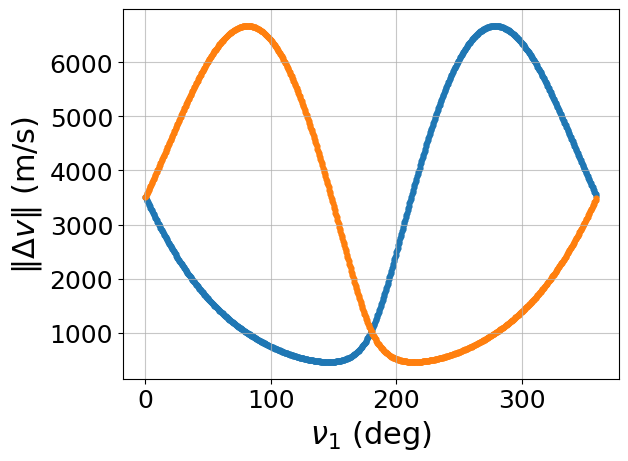

In [38]:
fig, ax = plt.subplots()
ax.scatter(xs_deg, dvA, s=12)
ax.scatter(xs_deg, dvB, s=12)
ax.set_xlabel(r"$\nu_1$ (deg)", fontsize=label_font_size)
ax.set_ylabel(r"$\|\Delta v\|$ (m/s)", fontsize=label_font_size)
ax.grid(True, alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=tick_params_font_size)
plt.show()

### Коррекция большой полуоси и аргумента перицентра

In [39]:
def solve_quadratic(a: float, b: float, c: float, tol: float = 1e-15) -> list[float]:
    """
    Решает a x^2 + b x + c = 0 в действительных числах.
    Возвращает 0, 1 или 2 корня (только вещественные). Если D<0 -> [].

    Численно устойчивый вариант (Kahan):
      q = -0.5 * (b + sign(b)*sqrt(D)), затем x1 = q/a, x2 = c/q.
    """
    # Линейный (или вырожденный) случай
    if abs(a) < tol:
        if abs(b) < tol:
            return []  # либо беск. много, если |c|<tol; тут считаем, что решений нет
        return [-c / b]

    D = b*b - 4.0*a*c
    if D < 0.0:
        return []  # нет действительных решений

    sqrtD = math.sqrt(D)

    # Устойчивое вычисление
    q = -0.5 * (b + (sqrtD if b >= 0 else -sqrtD))
    x1 = q / a
    # Если q почти ноль, используем стандартную формулу для второго корня
    x2 = c / q if abs(q) > tol else (-b / (2.0*a))

    # Слить почти совпадающие корни
    if abs(x1 - x2) < tol:
        return [0.5*(x1 + x2)]
    return [x1, x2]

In [40]:
pos1 = KepTrue(a=26_222e3, e=0.7, w=266*deg, i=63.434*deg, raan=0*deg, nu=222*deg)
a2 = 26_554e3
w2 = 270*deg

In [41]:
dist = r(pos1.a, pos1.e, pos1.nu)
u = pos1.w + pos1.nu
nu2 = u - w2
print(f"nu2 = {nu2 / deg}")

nu2 = 217.99999999999997


In [42]:
e21, e22 = solve_quadratic(a2, dist * math.cos(nu2), dist - a2)
print(f"e21 = {e21}")
print(f"e22 = {e22}")

e21 = 0.7619724421730308
e22 = 0.06516786701549572


In [43]:
pos21 = KepTrue(a=a2, e=e21, w=w2, i=pos1.i, raan=pos1.raan, nu=nu2)
pos22 = KepTrue(a=a2, e=e22, w=w2, i=pos1.i, raan=pos1.raan, nu=nu2)

In [44]:
pos1_rv = convert_kep_true_to_cart(pos1, mu)
pos21_rv = convert_kep_true_to_cart(pos21, mu)
pos22_rv = convert_kep_true_to_cart(pos22, mu)
print(pos1_rv)
print(pos21_rv)
print(pos22_rv)

Cart(r=array([-17160066.69191526,   9822872.75508522,  19644932.19911726]), v=array([ -489.80182678, -1622.44275447, -3244.75117445]))
Cart(r=array([-17160066.69191527,   9822872.75508522,  19644932.19911727]), v=array([ -155.77707798, -1647.25978589, -3294.3831825 ]))
Cart(r=array([-17160066.69191526,   9822872.75508521,  19644932.19911726]), v=array([-2806.54480275, -1069.05347157, -2138.01842799]))


In [45]:
dv1 = pos21_rv.v - pos1_rv.v
dv2 = pos22_rv.v - pos1_rv.v
print(dv1)
print(np.linalg.norm(dv1))
print(dv2)
print(np.linalg.norm(dv2))

[334.0247488  -24.81703142 -49.63200804]
338.6026492492687
[-2316.74297598   553.3892829   1106.73274646]
2626.4795996279677


### Оптимизация коррекции большой полуоси и аргумента перицентра

In [46]:
def a_w_dV(o1: Keptrue, a2: float, w2: float, mu: float, tol: float = 1e-12):
    dist = r(o1.a, o1.e, o1.nu)
    u = o1.w + o1.nu
    nu2 = u - w2
    roots = solve_quadratic(a2, dist * math.cos(nu2), dist - a2)
    # фильтр физически допустимых эксцентриситетов
    roots = [e for e in roots if (0.0 - tol) <= e < (1.0 - tol)]
    
    # состояние до манёвра
    s1 = convert_kep_true_to_cart(o1, mu)

    # подготовим два значения (могут быть NaN)
    dv_vals = [math.nan, math.nan]

    # вспомогательная функция |Δv| для данного e2
    def dv_for_e2(e2):
        o2_here = KepTrue(a=a2, e=e2, i=o1.i, raan=o1.raan, w=w2, nu=nu2)
        s2 = convert_kep_true_to_cart(o2_here, mu)
        return float(np.linalg.norm(s2.v - s1.v))

    # посчитать для 1-го и 2-го корня, если есть
    for idx in range(min(2, len(roots))):
        dv_vals[idx] = dv_for_e2(roots[idx])

    return dv_vals[0], dv_vals[1]

In [47]:
a1, e1, i1, raan1, w1 = 26_222e3, 0.7, 63.434 * deg, 0.0 * deg, 266 * deg
a2, w2 = 26_554e3, 270*deg

N = 720  # число точек по истинной аномалии
nus = np.linspace(0.0, 2.0 * math.pi, N, endpoint=False)

xs_deg = np.rad2deg(nus)
dvA = np.empty(N)
dvB = np.empty(N)

for k, nu in enumerate(nus):
    o1 = KepTrue(a=a1, e=e1, i=i1, raan=raan1, w=w1, nu=nu)
    d1, d2 = a_w_dV(o1, a2, w2, mu)
    dvA[k], dvB[k] = d1, d2

In [48]:
tick_params_font_size = 18
label_font_size = 22

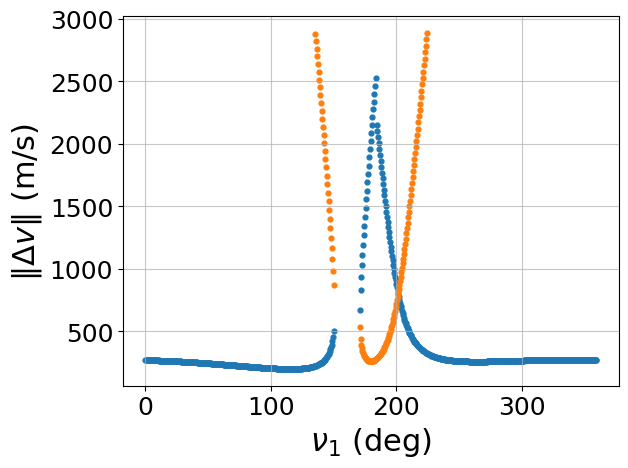

In [49]:
fig, ax = plt.subplots()
ax.scatter(xs_deg, dvA, s=12)
ax.scatter(xs_deg, dvB, s=12)
ax.set_xlabel(r"$\nu_1$ (deg)", fontsize=label_font_size)
ax.set_ylabel(r"$\|\Delta v\|$ (m/s)", fontsize=label_font_size)
ax.grid(True, alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=tick_params_font_size)
plt.show()

### Коррекция большой полуоси, эксцентриситета, долготы восходящего узла

In [50]:
def a_e_raan_dV(o1: Keptrue, a2: float, e2: float, raan2: float, mu: float):
    u = o1.w + o1.nu
    dist = r(o1.a, o1.e, o1.nu)
    nu1, nu2 = solve_true_anomaly(dist, a2, e2)
    nu1 = normalize_angle(nu1)
    nu2 = normalize_angle(nu2)
    w1 = normalize_angle(u - nu1)
    w2 = normalize_angle(u - nu2)
    
    o1_rv = convert_kep_true_to_cart(o1, mu)
    
    i2 = normalize_angle(np.arctan2(-o1_rv.r[2], o1_rv.r[0] * math.sin(raan2) - o1_rv.r[1] * math.cos(raan2)))

    o21 = KepTrue(a=a2, e=e2, w=w1, i=i2, raan=raan2, nu=nu1)
    o22 = KepTrue(a=a2, e=e2, w=w2, i=i2, raan=raan2, nu=nu2)

    o21_rv = convert_kep_true_to_cart(o21, mu)
    o22_rv = convert_kep_true_to_cart(o22, mu)

    dv1 = o21_rv.v - o1_rv.v
    dv2 = o22_rv.v - o1_rv.v

    return np.linalg.norm(dv1), np.linalg.norm(dv2)

In [51]:
a1, e1, i1, raan1, w1 = 26_000e3, 0.6, 64 * deg, 0.0 * deg, 250 * deg
a2, e2, raan2 = 26_554e3, 0.7, 3.0*deg

N = 720  # число точек по истинной аномалии
nus = np.linspace(0.0, 2.0 * math.pi, N, endpoint=False)

xs_deg = np.rad2deg(nus)
dvA = np.empty(N)
dvB = np.empty(N)

for k, nu in enumerate(nus):
    o1 = KepTrue(a=a1, e=e1, i=i1, raan=raan1, w=w1, nu=nu)
    d1, d2 = a_e_raan_dV(o1, a2, e2, raan2, mu)
    dvA[k] = d1
    dvB[k] = d2

In [52]:
tick_params_font_size = 18
label_font_size = 22

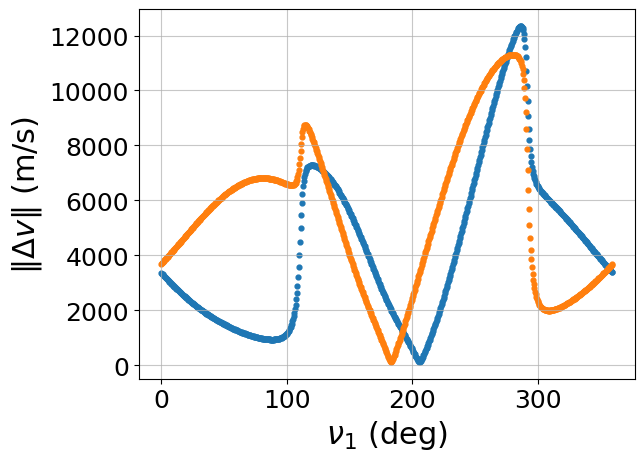

In [53]:
fig, ax = plt.subplots()
ax.scatter(xs_deg, dvA, s=12)
ax.scatter(xs_deg, dvB, s=12)
ax.set_xlabel(r"$\nu_1$ (deg)", fontsize=label_font_size)
ax.set_ylabel(r"$\|\Delta v\|$ (m/s)", fontsize=label_font_size)
ax.grid(True, alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=tick_params_font_size)
plt.show()